<a href="https://colab.research.google.com/github/juniorliu95/NLP_practice/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==0.17.0 # a package made by the author

     |████████████████████████████████| 83 kB 1.3 MB/s 


In [2]:
pip install -U ginza ja-ginza

     |████████████████████████████████| 58.7 MB 9.3 kB/s 
     |████████████████████████████████| 5.9 MB 46.8 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 627 kB 32.8 MB/s 
     |████████████████████████████████| 10.1 MB 36.6 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 456 kB 34.3 MB/s 
     |████████████████████████████████| 473 kB 35.5 MB/s 
  Created wheel for ginza: filename=ginza-5.0.3-py3-none-any.whl size=17874 sha256=9ac8edfb90ab1fbd767de67ee7199898ef532dc8b5c8073aeb1c4aa05c1b20fa
  Stored in directory: /root/.cache/pip/wheels/f7/66/a3/8c5acca83c2352f0130fb6dbd6a022e27331e25168654e066f
  Created wheel for SudachiDict-core: filename=SudachiDict_core-20210802-py3-none-any.whl size=71418512 sha256=6e1d46c0041571417e648a5ec79cf3d5b0c23bceeccaa3c886784a07b1830de4
  Stored in directory: /root/.cache/pip/wheels/91/e8/21/e80d212743835d87bb5e7eca81b6abef6d8cb67a294007a837
 

# Sentiment Analysis and the Dataset
:label:`sec_sentiment`


With the proliferation of online social media
and review platforms,
a plethora of
opinionated data
have been logged,
bearing great potential for
supporting decision making processes.
*Sentiment analysis*
studies people's sentiments
in their produced text,
such as product reviews,
blog comments,
and
forum discussions.
It enjoys wide applications
to fields as diverse as 
politics (e.g., analysis of public sentiments towards policies),
finance (e.g., analysis of sentiments of the market),
and 
marketing (e.g., product research and brand management).

Since sentiments
can be categorized
as discrete polarities or scales (e.g., positive and negative),
we can consider 
sentiment analysis 
as a text classification task,
which transforms a varying-length text sequence
into a fixed-length text category.
In this chapter,
we will use Stanford's [large movie review dataset](https://ai.stanford.edu/~amaas/data/sentiment/)
for sentiment analysis. 
It consists of a training set and a testing set, 
either containing 25000 movie reviews downloaded from IMDb.
In both datasets, 
there are equal number of 
"positive" and "negative" labels,
indicating different sentiment polarities.


In [3]:
import os
import torch
from torch import nn
from d2l import torch as d2l

##  Reading the Dataset

First, download and extract this IMDb review dataset
in the path `../data/aclImdb`.


In [4]:
d2l.DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

Next, read the training and test datasets. Each example is a review and its label: 1 for "positive" and 0 for "negative".


In [5]:
def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels."""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[0:60])

# trainings: 25000
label: 1 review: This movie has everything. Emotion, power, affection, Stepha
label: 1 review: Best Stephen King film alongside IT, though this one is more
label: 1 review: The cast really helps make this a pleasant surprise and a cu


## Preprocessing the Dataset

Treating each word as a token
and filtering out words that appear less than 5 times,
we create a vocabulary out of the training dataset.


In [6]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

In [7]:
len(train_tokens)

25000

`train_tokens` stores the tokenized corpora.

In [8]:
train_tokens[0][:10]

['This',
 'movie',
 'has',
 'everything.',
 'Emotion,',
 'power,',
 'affection,',
 'Stephane',
 "Rideau's",
 'adorable']

vocab select the vocabulary of tokens appeared more than 5 times.

In [31]:
len(vocab)

49347

In [30]:
list(zip(list(range(20)), vocab.idx_to_token[:20]))

[(0, '<unk>'),
 (1, '<pad>'),
 (2, 'the'),
 (3, 'a'),
 (4, 'and'),
 (5, 'of'),
 (6, 'to'),
 (7, 'is'),
 (8, 'in'),
 (9, 'I'),
 (10, 'that'),
 (11, 'this'),
 (12, 'it'),
 (13, '/><br'),
 (14, 'was'),
 (15, 'as'),
 (16, 'with'),
 (17, 'for'),
 (18, 'but'),
 (19, 'The')]

**Tokenization of English and other Latin languages are easy because we can just divide them by words.**

**But for languages like Japanese, Korean, Chinese, etc, we need to use specialized packages to do the tokenization.**

In [ ]:
import spacy
nlp = spacy.load('ja_ginza_electra')
doc = nlp('銀座でランチをご一緒しましょう。')
for sent in doc.sents:
    for token in sent:
        print(token.i, token.orth_, token.lemma_, token.pos_, token.tag_, token.dep_, token.head.i)
    print('EOS')

Cannot find the requested files in the cached path and outgoing traffic has been disabled. To enable model look-ups and downloads online, set 'local_files_only' to False.


Downloading:   0%|          | 0.00/775 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/434M [00:00<?, ?B/s]

0 銀座 銀座 PROPN 名詞-固有名詞-地名-一般 obl 5
1 で で ADP 助詞-格助詞 case 0
2 ランチ ランチ NOUN 名詞-普通名詞-一般 obj 5
3 を を ADP 助詞-格助詞 case 2
4 ご ご NOUN 接頭辞 compound 5
5 一緒 一緒 VERB 名詞-普通名詞-サ変可能 ROOT 5
6 し する AUX 動詞-非自立可能 aux 5
7 ましょう ます AUX 助動詞 aux 5
8 。 。 PUNCT 補助記号-句点 punct 5
EOS


After tokenization,
let us plot the histogram of
review lengths in tokens.


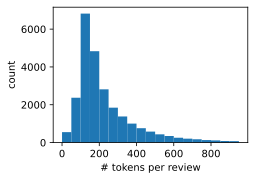

In [ ]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

As we expected,
the reviews have varying lengths.
To process
a minibatch of such reviews at each time,
we set the length of each review to 500 with truncation and padding,
which is similar to 
the preprocessing step 
for the machine translation dataset
in :numref:`sec_machine_translation`.


In [ ]:
num_steps = 500  # sequence length
train_features = torch.tensor([
    d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>'])
    for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


## Creating Data Iterators

Now we can create data iterators.
At each iteration, a minibatch of examples are returned.


In [ ]:
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


## Putting All Things Together

Last, we wrap up the above steps into the `load_data_imdb` function.
It returns training and test data iterators and the vocabulary of the IMDb review dataset.


In [ ]:
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([
        d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>'])
        for line in train_tokens])
    test_features = torch.tensor([
        d2l.truncate_pad(vocab[line], num_steps, vocab['<pad>'])
        for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size, is_train=False)
    return train_iter, test_iter, vocab

## Summary

* Sentiment analysis studies people's sentiments in their produced text, which is considered as a text classification problem that transforms a varying-length text sequence
into a fixed-length text category.
* After preprocessing, we can load Stanford's large movie review dataset (IMDb review dataset) into data iterators with a vocabulary.


# Sentiment Analysis: Using Recurrent Neural Networks
:label:`sec_sentiment_rnn`


Like word similarity and analogy tasks,
we can also apply pretrained word vectors
to sentiment analysis.
Since the IMDb review dataset
in :numref:`sec_sentiment`
is not very big,
using text representations
that were pretrained
on large-scale corpora
may reduce overfitting of the model.
As a specific example
illustrated in :numref:`fig_nlp-map-sa-rnn`,
we will represent each token
using the pretrained GloVe model,
and feed these token representations
into a multilayer bidirectional RNN
to obtain the text sequence representation,
which will
be transformed into 
sentiment analysis outputs :cite:`Maas.Daly.Pham.ea.2011`.
For the same downstream application,
we will consider a different architectural
choice later.

This section feeds pretrained GloVe to an RNN-based architecture for sentiment analysis.
:label:`fig_nlp-map-sa-rnn`


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## Representing Single Text with RNNs

In text classifications tasks,
such as sentiment analysis,
a varying-length text sequence 
will be transformed into fixed-length categories.
In the following `BiRNN` class,
while each token of a text sequence
gets its individual
pretrained GloVe
representation via the embedding layer
(`self.embedding`),
the entire sequence
is encoded by a bidirectional RNN (`self.encoder`).
More concretely,
the hidden states (at the last layer)
of the bidirectional LSTM
at both the initial and final time steps
are concatenated 
as the representation of the text sequence.
This single text representation
is then transformed into output categories
by a fully-connected layer (`self.decoder`)
with two outputs ("positive" and "negative").


In [ ]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                               bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully-connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        outs = self.decoder(encoding)
        return outs

Let us construct a bidirectional RNN with two hidden layers to represent single text for sentiment analysis.


In [ ]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

net.apply(init_weights);

## Loading Pretrained Word Vectors

Below we load the pretrained 100-dimensional (needs to be consistent with `embed_size`) GloVe embeddings for tokens in the vocabulary.


In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

Print the shape of the vectors
for all the tokens in the vocabulary.


In [ ]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

We use these pretrained
word vectors
to represent tokens in the reviews
and will not update
these vectors during training.


In [ ]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

## Training and Evaluating the Model

Now we can train the bidirectional RNN for sentiment analysis.


loss 0.294, train acc 0.874, test acc 0.856
277.8 examples/sec on [device(type='cuda', index=0)]


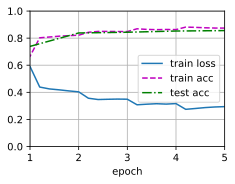

In [ ]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

We define the following function to predict the sentiment of a text sequence using the trained model `net`.


In [ ]:
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

Finally, let us use the trained model to predict the sentiment for two simple sentences.


In [ ]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## Summary

* Pretrained word vectors can represent individual tokens in a text sequence.
* Bidirectional RNNs can represent a text sequence, such as via the concatenation of its hidden states at the initial and final time steps. This single text representation can be transformed into categories using a fully-connected layer.

# Sentiment Analysis: Using Convolutional Neural Networks 
:label:`sec_sentiment_cnn`


In :numref:`chap_cnn`,
we investigated mechanisms
for processing
two-dimensional image data
with two-dimensional CNNs,
which were applied to
local features such as adjacent pixels.
Though originally 
designed for computer vision,
CNNs are also widely used
for natural language processing.
Simply put,
just think of any text sequence
as a one-dimensional image.
In this way,
one-dimensional CNNs
can process local features
such as $n$-grams in text.

In this section,
we will use the *textCNN* model
to demonstrate
how to design a CNN architecture
for representing single text :cite:`Kim.2014`.
Compared with 
:numref:`fig_nlp-map-sa-rnn`
that uses an RNN architecture with GloVe pretraining
for sentiment analysis,
the only difference in :numref:`fig_nlp-map-sa-cnn`
lies in
the choice of the architecture.


![This section feeds pretrained GloVe to a CNN-based architecture for sentiment analysis.](https://github.com/juniorliu95/NLP_practice/blob/img/nlp-map-sa-cnn.svg?raw=1)
:label:`fig_nlp-map-sa-cnn`


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## One-Dimensional Convolutions

Before introducing the model, 
let us see how a one-dimensional convolution works.
Bear in mind that it is just a special case
of a two-dimensional convolution
based on the cross-correlation operation.

![One-dimensional cross-correlation operation. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times1+1\times2=2$.](http://d2l.ai/_images/conv1d.svg)
:label:`fig_conv1d`

As shown in :numref:`fig_conv1d`,
in the one-dimensional case,
the convolution window
slides from left to right
across the input tensor.
During sliding,
the input subtensor (e.g., $0$ and $1$ in :numref:`fig_conv1d`) contained in the convolution window
at a certain position
and the kernel tensor (e.g., $1$ and $2$ in :numref:`fig_conv1d`) are multiplied elementwise.
The sum of these multiplications
gives the single scalar value (e.g., $0\times1+1\times2=2$ in :numref:`fig_conv1d`)
at the corresponding position of the output tensor.

We implement one-dimensional cross-correlation in the following `corr1d` function. 
Given an input tensor `X`
and a kernel tensor `K`,
it returns the output tensor `Y`.


In [ ]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i:i + w] * K).sum()
    return Y

We can construct the input tensor `X` and the kernel tensor `K` from :numref:`fig_conv1d` to validate the output of the above one-dimensional cross-correlation implementation.


In [ ]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

For any
one-dimensional input with multiple channels,
the convolution kernel
needs to have the same number of input channels.
Then for each channel, 
perform a cross-correlation operation on the one-dimensional tensor of the input and the one-dimensional tensor of the convolution kernel, 
summing the results over all the channels
to produce the one-dimensional output tensor.
:numref:`fig_conv1d_channel` shows a one-dimensional cross-correlation operation with 3 input channels.

![One-dimensional cross-correlation operation with 3 input channels. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times1+1\times2+1\times3+2\times4+2\times(-1)+3\times(-3)=2$.](https://github.com/juniorliu95/NLP_practice/blob/img/conv1d-channel.svg?raw=1)
:label:`fig_conv1d_channel`


We can implement the one-dimensional cross-correlation operation for multiple input channels
and validate the results in :numref:`fig_conv1d_channel`.


In [ ]:
def corr1d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7],
                  [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

Note that
multi-input-channel one-dimensional cross-correlations
are equivalent
to 
single-input-channel 
two-dimensional cross-correlations.
To illustrate,
an equivalent form of
the multi-input-channel one-dimensional cross-correlation
in :numref:`fig_conv1d_channel`
is 
the 
single-input-channel 
two-dimensional cross-correlation
in :numref:`fig_conv1d_2d`,
where the height of the convolution kernel
has to be the same as that of the input tensor.


![Two-dimensional cross-correlation operation with a single input channel. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $2\times(-1)+3\times(-3)+1\times3+2\times4+0\times1+1\times2=2$.](https://github.com/juniorliu95/NLP_practice/blob/img/conv1d-2d.svg?raw=1)
:label:`fig_conv1d_2d`

Both the outputs in :numref:`fig_conv1d` and :numref:`fig_conv1d_channel` have only one channel.
Same as two-dimensional convolutions with multiple output channels described in :numref:`subsec_multi-output-channels`,
we can also specify multiple output channels
for one-dimensional convolutions.

## Max-Over-Time Pooling

Similarly, we can use pooling
to extract the highest value
from sequence representations
as the most important feature
across time steps.
The *max-over-time pooling* used in textCNN 
works like
the one-dimensional global maximum pooling
:cite:`Collobert.Weston.Bottou.ea.2011`. 
For a multi-channel input
where each channel stores values
at different time steps,
the output at each channel
is the maximum value 
for that channel.
Note that
the max-over-time pooling
allows different numbers of time steps
at different channels.

## The textCNN Model

Using the one-dimensional convolution
and max-over-time pooling,
the textCNN model
takes individual pretrained token representations
as the input,
then obtains and transforms sequence representations
for the downstream application.

For a single text sequence
with $n$ tokens represented by 
$d$-dimensional vectors,
the width, height, and number of channels
of the input tensor
are $n$, $1$, and $d$, respectively.
The textCNN model transforms the input
into the output as follows:

1. Define multiple one-dimensional convolution kernels and perform convolution operations separately on the inputs. Convolution kernels with different widths may capture local features among different numbers of adjacent tokens.
1. Perform max-over-time pooling on all the output channels, and then concatenate all the scalar pooling outputs as a vector.
1. Transform the concatenated vector into the output categories using the fully-connected layer. Dropout can be used for reducing overfitting.

![The model architecture of textCNN.](http://d2l.ai/_images/textcnn.svg)
:label:`fig_conv1d_textcnn`

:numref:`fig_conv1d_textcnn` 
illustrates the model architecture of textCNN
with a concrete example.
The input is a sentence with 11 tokens,
where
each token is represented by a 6-dimensional vectors.
So we have a 6-channel input with width 11.
Define
two one-dimensional convolution kernels
of widths 2 and 4,
with 4 and 5 output channels, respectively.
They produce
4 output channels with width $11-2+1=10$
and 5 output channels with width $11-4+1=8$.
Despite different widths of these 9 channels,
the max-over-time pooling
gives a concatenated 9-dimensional vector,
which is finally transformed
into a 2-dimensional output vector
for binary sentiment predictions.



### Defining the Model

We implement the textCNN model in the following class.
Compared with the bidirectional RNN model in
:numref:`sec_sentiment_rnn`,
besides
replacing recurrent layers with convolutional layers,
we also use two embedding layers:
one with trainable weights and the other 
with fixed weights.


In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat(
            (self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

Let us create a textCNN instance. 
It has 3 convolutional layers with kernel widths of 3, 4, and 5, all with 100 output channels.


In [ ]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights);

### Loading Pretrained Word Vectors

Same as :numref:`sec_sentiment_rnn`,
we load pretrained 100-dimensional GloVe embeddings
as the initialized token representations.
These token representations (embedding weights)
will be trained in `embedding`
and fixed in `constant_embedding`.


In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

### Training and Evaluating the Model

Now we can train the textCNN model for sentiment analysis.


loss 0.034, train acc 0.990, test acc 0.872
1134.7 examples/sec on [device(type='cuda', index=0)]


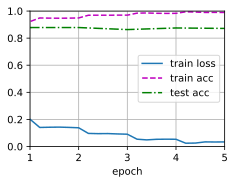

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

Below we use the trained model to predict the sentiment for two simple sentences.


In [ ]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

In [ ]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

## Summary

* One-dimensional CNNs can process local features such as $n$-grams in text.
* Multi-input-channel one-dimensional cross-correlations are equivalent to single-input-channel two-dimensional cross-correlations.
* The max-over-time pooling allows different numbers of time steps at different channels.
* The textCNN model transforms individual token representations into downstream application outputs using one-dimensional convolutional layers and max-over-time pooling layers.
